## Image网 Submission `192x192` - Contrastive Learning

This contains a submission for the Image网 leaderboard in the `192x192` category.

Inspired by the paper: [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/abs/2002.05709)

Code run on Titan RTX

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do contrastive learning on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch

import numpy as np

from functools import partial
from fastai2.basics import *
from fastai2.vision.all import *

In [2]:
# torch.cuda.set_device(4)

In [3]:
# Chosen parameters
lr=2e-2
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
bs=64 
sa=1
wd=1e-2

m = xresnet34
act_fn = torch.nn.ReLU
pool = MaxPool

nc=20

In [4]:
source = untar_data(URLs.IMAGEWANG_160)
len(get_image_files(source/'unsup')), len(get_image_files(source/'train')), len(get_image_files(source/'val'))

(7750, 14669, 3929)

In [5]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [6]:
m_part = partial(m, c_out=nc, act_cls=torch.nn.ReLU, sa=sa, pool=pool)
model_meta[m_part] = model_meta[xresnet34]

In [7]:
save_name = 'imagewang_192_temp5'

## 1. Pretext Task: Contrastive Learning

In [8]:
def remove_diag(x):
    bs = x.shape[0]
    return x[~torch.eye(bs).bool()].reshape(bs,bs-1)

class XentContrastiveLoss(nn.Module):
    def __init__(self, temp=0.5):
        super().__init__()
        self.temp = temp

    def forward(self, input, labels):
        bs,feat = input.shape
        csim = F.cosine_similarity(input, input.unsqueeze(dim=1), dim=-1)/self.temp
        csim = remove_diag(csim) # remove self similarity
        labels =  remove_diag(torch.eye(labels.shape[0], device=input.device)[labels]).nonzero()[:,-1]
        return F.cross_entropy(csim, labels)
    
class ContrastCallback(Callback):
    def __init__(self, size=256, aug_targ=None, aug_pos=None, temperature=0.1):
        self.aug_targ = ifnone(aug_targ, get_aug_pipe(size))
        self.aug_pos = ifnone(aug_pos, get_aug_pipe(size))
        self.temperature = temperature
        
    def update_size(self, size):
        pipe_update_size(self.aug_targ, size)
        pipe_update_size(self.aug_pos, size)
        
    def begin_fit(self): 
        self.old_lf = self.learn.loss_func
        self.old_met = self.learn.metrics
        self.learn.metrics = []
        self.learn.loss_func = XentContrastiveLoss(self.temperature)
        
    def after_fit(self):
        self.learn.loss_fun = self.old_lf
        self.learn.metrics = self.old_met
        
    def begin_batch(self):
        xb, = self.learn.xb
        xb_targ = self.aug_targ(xb)
        xb_pos = self.aug_pos(xb)
        self.learn.xb = torch.cat((xb_targ, xb_pos), dim=0),
        bs = self.learn.xb[0].shape[0]
        self.learn.yb = torch.arange(bs, device=xb.device).roll(bs//2),

In [9]:
def get_dbunch(size, bs, workers=8):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=0.9)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [10]:
size = 192
bs = 256

dbunch = get_dbunch(224, bs) # first resize to 224, then 192 w/ get_aug_pipe
len(dbunch.train.dataset)

23714

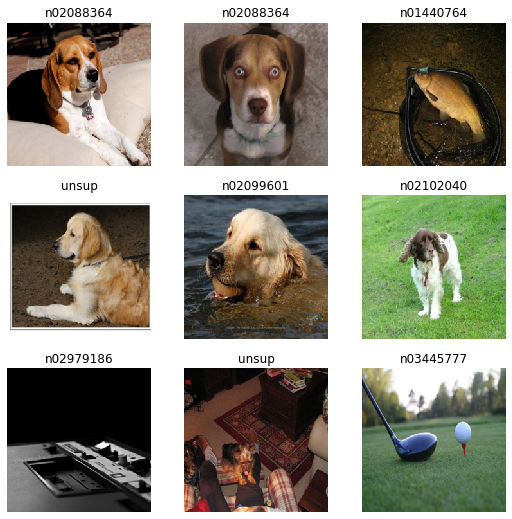

In [11]:
dbunch.show_batch()

In [12]:
import kornia

In [13]:
#export
def get_aug_pipe(size, stats=None, s=.6):
    stats = ifnone(stats, imagenet_stats)
    rrc = kornia.augmentation.RandomResizedCrop((size,size), scale=(0.2, 1.0), ratio=(3/4, 4/3))
    rhf = kornia.augmentation.RandomHorizontalFlip()
    rcj = kornia.augmentation.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    
    tfms = [rrc, rhf, rcj, Normalize.from_stats(*stats)]
    pipe = Pipeline(tfms)
    pipe.split_idx = 0
    return pipe

In [14]:
aug = get_aug_pipe(size)
aug2 = get_aug_pipe(size)
cbs = ContrastCallback(size=size, aug_targ=aug, aug_pos=aug2, temperature=0.5)

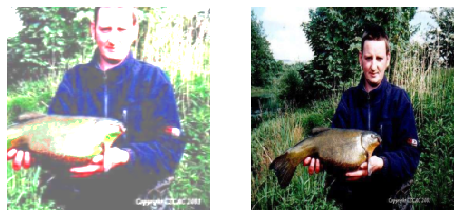

In [15]:
xb,yb = dbunch.one_batch()
nrm = Normalize.from_stats(*imagenet_stats)
xb_dec = nrm.decodes(aug(xb))
show_images([xb_dec[0], xb[0]])

In [16]:
ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128))
learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                    metrics=[], loss_func=CrossEntropyLossFlat(), cbs=cbs, pretrained=False,
                    config={'custom_head':ch}
                   ).to_fp16()

In [17]:
learn.unfreeze()
learn.fit_flat_cos(80, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,5.341545,5.398299,03:15
1,5.080853,5.007387,03:10
2,4.980040,5.055075,03:12
3,4.926264,5.019688,03:12
4,4.900654,4.876271,03:10
5,4.870821,4.857622,03:10
6,4.839160,4.987493,03:11
7,4.824240,4.882557,03:11
8,4.806241,4.797034,03:10
9,4.763361,4.750838,03:09


In [18]:
torch.save(learn.model[0].state_dict(), f'{save_name}.pth')

## 2. Downstream Task: Image Classification

In [19]:
def get_dbunch(size, bs, workers=8):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source)
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [20]:
def do_train(epochs=5, runs=5, size=size, bs=bs, lr=lr, save_name=None):
    dbunch = get_dbunch(size, bs)
    for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, nc))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func, normalize=False,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy(),
                pretrained=False,
                config={'custom_head':ch})

        if save_name is not None:
            state_dict = torch.load(f'{save_name}.pth')
            learn.model[0].load_state_dict(state_dict)
            
        learn.unfreeze()
        learn.fit_flat_cos(epochs, lr, wd=wd)

### 5 Epochs

In [21]:
epochs = 5
runs = 5

In [22]:
do_train(epochs, runs, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.435125,2.085925,0.395775,0.871214,00:33
1,1.098149,1.755271,0.545686,0.909901,00:30
2,0.972559,1.984168,0.472130,0.857470,00:31
3,0.911296,1.696609,0.583100,0.934080,00:31
4,0.841191,1.563898,0.630440,0.940952,00:31


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.462591,2.069648,0.390939,0.839908,00:31
1,1.105098,1.802945,0.522016,0.905065,00:31
2,0.973930,2.201098,0.397048,0.831000,00:31
3,0.915493,1.677095,0.587427,0.919318,00:31
4,0.838028,1.582339,0.628150,0.938152,00:33


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.423322,2.272237,0.327055,0.817256,00:31
1,1.095166,1.783047,0.535760,0.909137,00:31
2,0.969067,2.412230,0.324256,0.833291,00:31
3,0.903344,1.686338,0.589718,0.914482,00:31
4,0.834177,1.546751,0.644948,0.934843,00:31


Run: 3


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.421447,2.090805,0.406465,0.855943,00:31
1,1.109158,1.878077,0.490201,0.903283,00:31
2,0.975509,1.985152,0.466276,0.903538,00:31
3,0.907588,1.680138,0.592263,0.931026,00:31
4,0.837064,1.534070,0.651311,0.942734,00:33


Run: 4


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.409604,2.193190,0.326801,0.836345,00:31
1,1.091456,1.842848,0.516162,0.921863,00:31
2,0.967164,2.001653,0.478239,0.838381,00:31
3,0.915219,1.772356,0.555612,0.930517,00:31
4,0.838644,1.524265,0.654110,0.940952,00:31


In [23]:
accuracies = [0.649784, 0.650038, 0.638330, 0.649275, 0.652838]
avg_acc = tensor(accuracies).mean().item()
f'Average Accuracy: {avg_acc*100:.2f}%'

'Average Accuracy: 64.81%'

### 20 Epochs

In [24]:
epochs = 20
runs = 3

In [25]:
do_train(epochs, runs, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.442442,2.290641,0.295750,0.847289,00:31
1,1.103940,1.764608,0.546704,0.902520,00:31
2,0.967678,1.992100,0.499109,0.843726,00:31
3,0.912865,1.727628,0.574446,0.913973,00:32
4,0.872458,1.987697,0.497073,0.862306,00:31
5,0.845508,1.686378,0.604989,0.902265,00:31
6,0.821401,1.691199,0.574955,0.919318,00:31
7,0.806171,1.599419,0.628913,0.925935,00:31
8,0.783714,2.187219,0.447188,0.821583,00:31
9,0.775570,1.623988,0.628404,0.917027,00:31


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.416386,2.273845,0.344617,0.791295,00:31
1,1.094024,1.692557,0.584882,0.925172,00:31
2,0.969488,1.846327,0.525325,0.894884,00:31
3,0.910018,1.635456,0.613133,0.923390,00:31
4,0.866451,1.868457,0.512599,0.880377,00:31
5,0.847473,1.595326,0.631967,0.931026,00:31
6,0.830506,1.833549,0.533469,0.894375,00:31
7,0.807282,1.565548,0.637821,0.929244,00:31
8,0.790142,1.805082,0.569865,0.900484,00:31
9,0.776956,1.694752,0.599135,0.919572,00:31


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.415278,2.163198,0.346908,0.839399,00:31
1,1.093160,1.731655,0.552303,0.919572,00:31
2,0.964814,1.992495,0.479257,0.898956,00:31
3,0.911646,1.733378,0.559684,0.911173,00:32
4,0.874293,2.077950,0.485365,0.896157,00:31
5,0.850065,1.661867,0.616951,0.925681,00:31
6,0.824446,2.361642,0.445151,0.825655,00:31
7,0.800717,1.647083,0.607788,0.916518,00:31
8,0.781044,1.624393,0.628150,0.925172,00:31
9,0.775230,1.679043,0.607788,0.909392,00:31


In [26]:
accuracies = [0.681344, 0.692034, 0.677272]
avg_acc = tensor(accuracies).mean().item()
f'Average Accuracy: {avg_acc*100:.2f}%'

'Average Accuracy: 68.36%'

## 80 epochs

In [27]:
epochs = 80
runs = 1

In [28]:
do_train(epochs, runs, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.426192,2.182256,0.349453,0.874014,00:31
1,1.090311,1.810705,0.523543,0.910155,00:33
2,0.962626,1.820641,0.528888,0.895393,00:32
3,0.911741,1.706376,0.575719,0.918809,00:31
4,0.877261,1.800221,0.561212,0.898956,00:31
5,0.851147,1.603812,0.629931,0.932807,00:30
6,0.822117,1.719374,0.588699,0.906337,00:31
7,0.804609,1.731918,0.598371,0.906847,00:31
8,0.786163,1.978987,0.524052,0.872996,00:31
9,0.772043,1.621121,0.628404,0.926190,00:31


Accuracy: **68.31%**

### 200 epochs

In [28]:
epochs = 200
runs = 1

In [29]:
do_train(epochs, runs, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.490832,1.976736,0.458386,0.885467,00:31
1,1.104492,1.761846,0.560193,0.912955,00:31
2,0.961788,1.782201,0.559430,0.926190,00:31
3,0.892280,1.641475,0.603207,0.922118,00:31
4,0.847929,2.407284,0.441079,0.851616,00:31
5,0.824030,1.544538,0.634767,0.938152,00:31
6,0.801017,2.105922,0.468058,0.807839,00:31
7,0.771616,1.758301,0.590227,0.900484,00:31
8,0.761082,1.855665,0.569356,0.882922,00:31
9,0.752170,1.617880,0.629931,0.923899,00:30


Accuracy: **67.93%**